# Importing model configurations

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import theano
import lasagne
import json
from lasagne import layers
from lasagne.updates import adadelta
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import TrainSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import morelearn # Custom package
%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


Load CIFAR10

In [2]:
Xtr, Ytr, Xte, Yte, labelNames = morelearn.load_CIFAR10('CNNs4VR/Mod1_NNs/cifar-10-batches-py/')

In [4]:
Xte.shape

(10000, 32, 32, 3)

In [451]:
def adapt_dataset(Xte):
    Xte_in = np.copy(Xte)
    Xte_in = np.swapaxes(Xte_in,1,3) # Bring color axis to 2nd position
    Xte_in = np.swapaxes(Xte_in,2,3) # Swap xy axes
    Xte_in = Xte_in.astype(np.float)
    Xte_in -= 128
    Xte_in /= 128
    print(Xte_in.shape)
    print(np.min(Xte_in))
    print(np.max(Xte_in))
    return (Xte_in)

In [452]:
Xte_in = adapt_dataset(Xte)
Xtr_in = adapt_dataset(Xtr)

(10000, 3, 32, 32)
-1.0
0.9921875
(50000, 3, 32, 32)
-1.0
0.9921875


Define Architecture using the network definition from [here](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html).
```javascript
layer_defs = [];
layer_defs.push({type:'input', out_sx:32, out_sy:32, out_depth:3});
layer_defs.push({type:'conv', sx:5, filters:16, stride:1, pad:2, activation:'relu'});
layer_defs.push({type:'pool', sx:2, stride:2});
layer_defs.push({type:'conv', sx:5, filters:20, stride:1, pad:2, activation:'relu'});
layer_defs.push({type:'pool', sx:2, stride:2});
layer_defs.push({type:'conv', sx:5, filters:20, stride:1, pad:2, activation:'relu'});
layer_defs.push({type:'pool', sx:2, stride:2});
layer_defs.push({type:'softmax', num_classes:10});

net = new convnetjs.Net();
net.makeLayers(layer_defs);

trainer = new convnetjs.SGDTrainer(net, {method:'adadelta', batch_size:4, l2_decay:0.0001});
```

In [398]:
net1 = NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('conv2d3', layers.Conv2DLayer),
            ('maxpool3', layers.MaxPool2DLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 3, 32, 32),
    # layer conv2d1
    conv2d1_num_filters=16,
    conv2d1_pad='same', # Pad input with zeroes for same size output
    conv2d1_filter_size=(5, 5),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),
    conv2d1_b=None,
    conv2d1_flip_filters=True,
    # layer maxpool1
    maxpool1_pool_size=(2, 2), 
    # layer conv2d2
    conv2d2_num_filters=20,
    conv2d2_filter_size=(5, 5),
    conv2d2_pad='same',
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d2_W=lasagne.init.GlorotUniform(),
    conv2d2_b=None,
    conv2d2_flip_filters=True,
    # layer maxpool2
    maxpool2_pool_size=(2, 2),
    # layer conv2d3
    conv2d3_num_filters=20,
    conv2d3_filter_size=(5, 5),
    conv2d3_pad='same',
    conv2d3_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_W=lasagne.init.GlorotUniform(),
    conv2d3_b=None,
    conv2d3_flip_filters=True,
    # layer maxpool3
    maxpool3_pool_size=(2, 2),
    # output
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=10,
    output_b=None,
    # optimization method params
    objective_l2 = 0.0001,
    update=adadelta,
    max_epochs=10,
    verbose=1,
    )

Getting model parameters from the same site, via the "load a pretrained network" and "save network snapshot as JSON" functionalities. The resulting JSON script has been saved to file on disk.

In [414]:
importlib.reload(morelearn)

<module 'morelearn' from '/home/czb/Documents/NotebookTest/morelearn/__init__.py'>

In [415]:
loadableParams = morelearn.get_params_from_ConvNetJS("pretrained_CIFAR10.json",
                                                     ['conv2d1','conv2d2','conv2d3'],
                                                     ['output'])

In [416]:
# net1.load_params_from('cifar10_overfitting')
net1.load_params_from(loadableParams)

Loaded parameters to layer 'conv2d1' (shape 16x3x5x5).
Loaded parameters to layer 'conv2d2' (shape 20x16x5x5).
Loaded parameters to layer 'conv2d3' (shape 20x20x5x5).
Loaded parameters to layer 'output' (shape 320x10).


In [355]:
nn = net1.fit(Xtr_in,Ytr)

# Neural Network with 22400 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     3x32x32
  1  conv2d1   16x32x32
  2  maxpool1  16x16x16
  3  dropout1  16x16x16
  4  conv2d2   20x16x16
  5  maxpool2  20x8x8
  6  dropout2  20x8x8
  7  conv2d3   20x8x8
  8  maxpool3  20x4x4
  9  dropout3  20x4x4
 10  output    10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     1.96534     1.82630    1.07613      0.38780  15.83s
      2     1.72103     1.64795    1.04435      0.42570  15.61s
      3     1.64212     1.63228    1.00603      0.42080  15.55s
      4     1.60637     1.55077    1.03586      0.46170  15.74s
      5     1.57466     1.43216    1.09950      0.49050  15.81s
      6     1.56012     1.45300    1.07372      0.49010  15.84s
      7     1.54517     1.43001    1.08053      0.50200  15.66s
      8     1.52804     1.48829    1.02671      0.46550  15.69s

In [440]:
preds = net1.predict(Xte_in)

In [441]:
print("Classification report")
print(classification_report(Yte, preds, target_names=labelNames))

Classification report
             precision    recall  f1-score   support

   airplane       0.11      0.10      0.10      1000
 automobile       0.05      0.01      0.02      1000
       bird       0.10      0.23      0.14      1000
        cat       0.10      0.12      0.11      1000
       deer       0.08      0.18      0.11      1000
        dog       0.10      0.10      0.10      1000
       frog       0.05      0.01      0.01      1000
      horse       0.08      0.05      0.06      1000
       ship       0.14      0.03      0.05      1000
      truck       0.12      0.16      0.14      1000

avg / total       0.09      0.10      0.08     10000



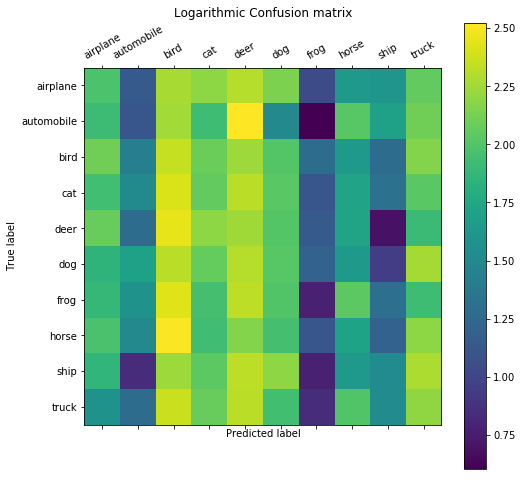

In [442]:
confmat = np.log10(confusion_matrix(Yte, preds)+1)
plt.figure(figsize=(8,8))
plt.matshow(confmat, fignum=1)
plt.title('Logarithmic Confusion matrix',y=1.125)
plt.colorbar()
plt.ylabel('True label')
plt.xticks(range(len(labelNames)),labelNames,rotation='30')
plt.yticks(range(len(labelNames)),labelNames,rotation='horizontal')
plt.xlabel('Predicted label')
plt.show()

In [362]:
va_loss, tr_loss, va_acc, durs, epochs = morelearn.get_history(net1)

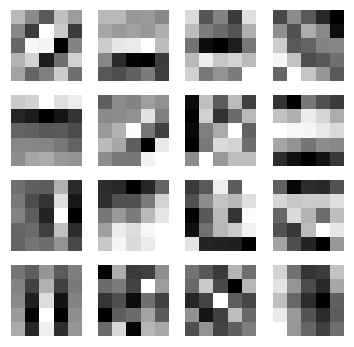

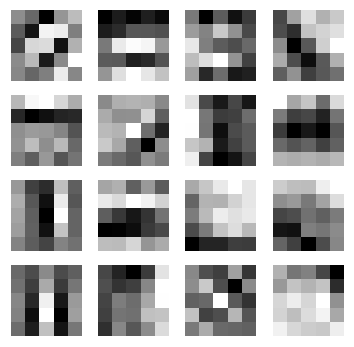

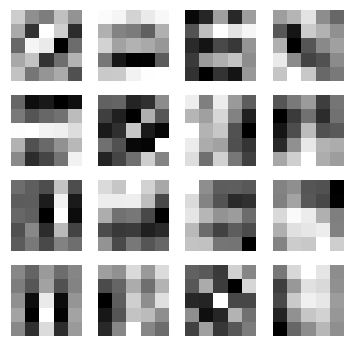

In [360]:
visualize.plot_conv_weights(net1.layers_['conv2d1'])
plt.show()

In [116]:
with open('cifar10_overfitting_loss.json','r') as f:
    bckp=json.load(f)

In [117]:
for var in ['va_loss', 'tr_loss', 'va_acc', 'durs', 'epochs' ]:
    if var == 'epochs':
        globals()[var] += bckp[var][len(bckp[var])-1]
    globals()[var] = np.concatenate((np.array(bckp[var]),globals()[var]))

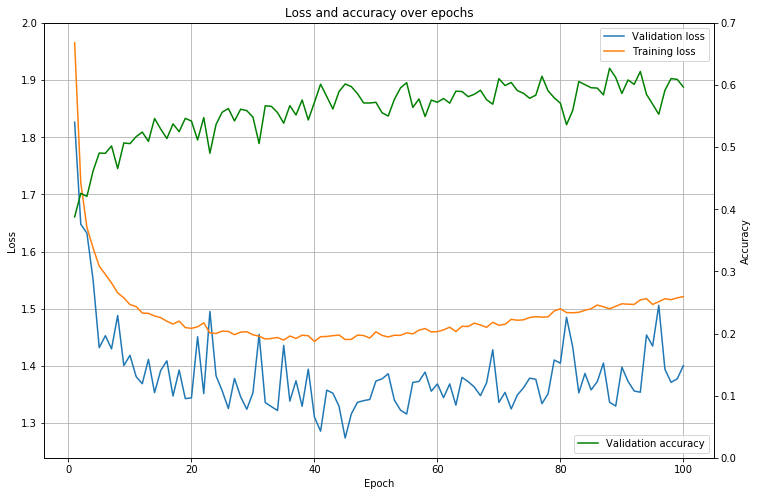

In [465]:
fig,ay1 = plt.subplots(figsize=(12,8))
ay2 = ay1.twinx()

ay1.plot(epochs,va_loss,'-')
ay1.plot(epochs,tr_loss,'-')
ay2.plot(epochs,va_acc,'g-')
ay1.set_ylabel("Loss")
ay2.set_ylabel("Accuracy")
ay2.set_ylim([0,0.7])

ay1.set_title("Loss and accuracy over epochs")
ay1.set_xlabel("Epoch")
ay1.legend(labels=["Validation loss","Training loss"],loc=1)
ay2.legend(labels=["Validation accuracy"],loc=4)
ay1.grid()
plt.savefig('cifar10_overfitting_loss.eps', format='eps', dpi=1200, transparent=True)
plt.savefig('cifar10_overfitting_loss.svg', format='svg', dpi=1200, transparent=True)
plt.savefig('cifar10_overfitting_loss.png', format='png', dpi=120, transparent=True)
plt.show()

In [443]:
for layer in ['conv2d1','conv2d2','conv2d3','output']:
    globals()['f_'+layer] = morelearn.make_theano_function(net1,layer)

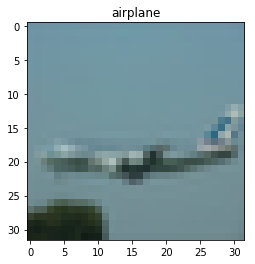

In [453]:
idx = 4991
plt.title(labelNames[Yte[idx]])
plt.imshow(Xte[idx])
plt.show()

In [454]:
instance=Xte_in[idx][None,:,:]
actual_value=Yte[idx]
instance.shape

(1, 3, 32, 32)

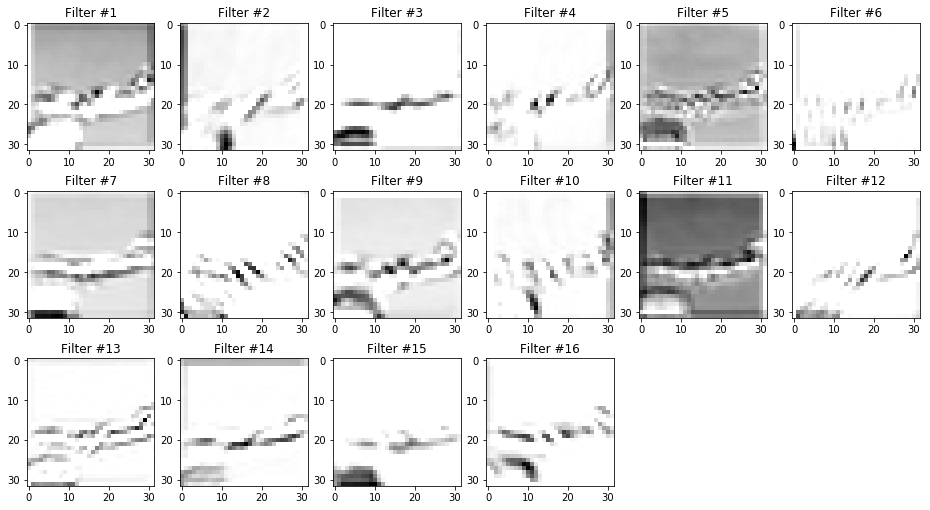

In [455]:
predConv2d1 = f_conv2d1(instance)
morelearn.plot_layer_outputs(predConv2d1)

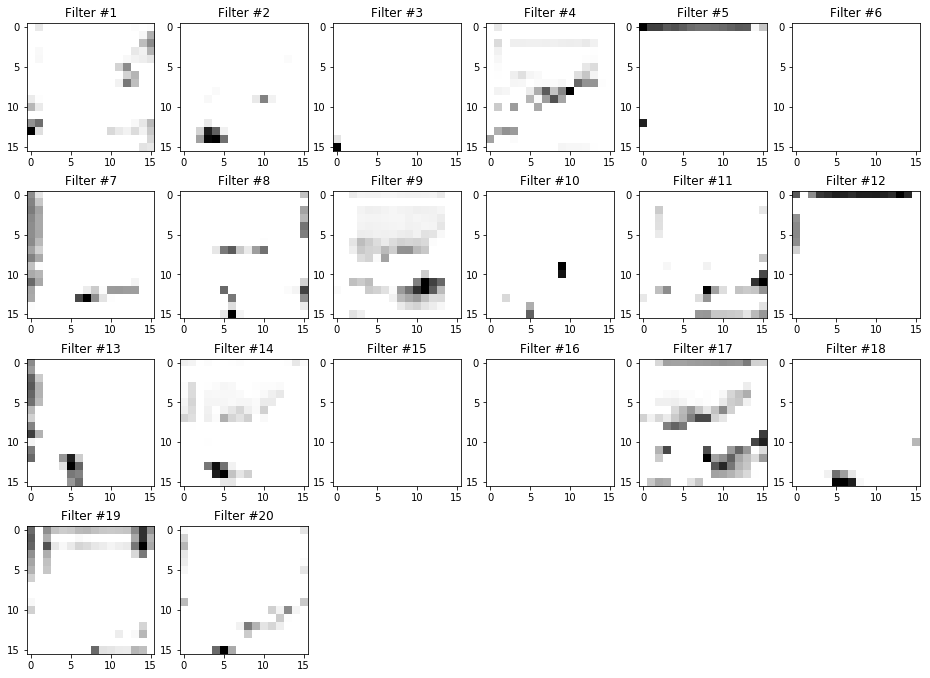

In [456]:
predConv2d2 = f_conv2d2(instance)
morelearn.plot_layer_outputs(predConv2d2)

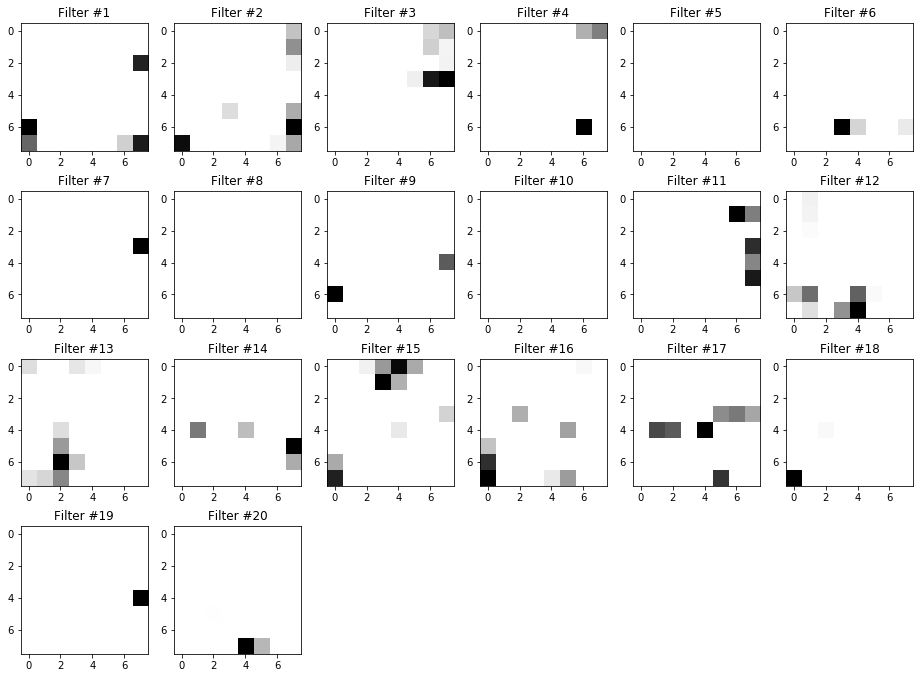

In [457]:
predConv2d3 = f_conv2d3(instance)
morelearn.plot_layer_outputs(predConv2d3)

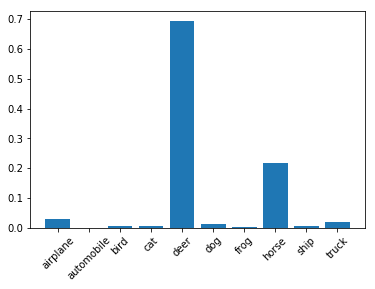

In [458]:
pred = f_output(instance)
morelearn.plot_layer_activation(pred,labelNames,rotation=45)

In [459]:
print("Prediction: %s" % labelNames[np.argmax(pred[0])])
print("Actual value: %s" % labelNames[actual_value])

Prediction: deer
Actual value: airplane
